# Caffeine Consumption through a GWAS Lens

## Introduction
Caffeine consumption is a prevalent behavior influenced by a combination of environmental and genetic factors. This project explores the genetic basis of caffeine consumption through a genome-wide association study (GWAS). By investigating the relationship between genetic variants and caffeine intake, we aim to identify loci that contribute to this behavioral trait.

Two datasets form the foundation of this analysis:

1. Genotype Data: A processed VCF file containing genotyping information for 284 individuals across 10,878 variants. Each variant includes genotype fields (GT), which have been cleaned and curated for analysis.
2. Phenotype Data: An annotations file providing demographic and phenotypic traits, including gender, superpopulation (ethnicity), and weekly caffeine consumption for 3,500 individuals. Of these, 284 overlap with the genotyped samples.

The structure of both datasets is shown below.

In [38]:
# Core libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for statistical analysis and regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2


In [39]:
# Reading the annotations file
annotations = pd.read_csv("data/annotations.txt", sep="\t")

# Display the first few rows to verify
display(annotations.head())


,Sample,SuperPopulation,isFemale,CaffeineConsumption
0,HG00096,EUR,False,4
1,HG00097,EUR,True,4
2,HG00098,EUR,False,5
3,HG00099,EUR,True,4
4,HG00100,EUR,True,5


In [ ]:
# Load the VCF file, skipping the first two comment lines
vcf_data = pd.read_csv("data/genotypes.vcf", delimiter='\t', skiprows=2, low_memory=False)

# Extract the column names from the third line of the file
with open("data/genotypes.vcf") as file:
    header_line = file.readlines()[2].strip()

# Assign the extracted column names to the DataFrame
vcf_data.columns = header_line.split("\t")

# Remove the leading # from the CHROM column name
vcf_data.columns = [col.lstrip('#') for col in vcf_data.columns]

# Separate annotations (first 9 columns) and genotype data (remaining columns)
comments = vcf_data.iloc[:, :9]
genotypes = vcf_data.iloc[:, 9:]

# Function to extract GT field from genotype data
def extract_gt(genotype):
    if pd.isna(genotype):  # Handle missing data
        return np.nan
    return genotype.split(":")[0]  # Extract only the GT field

# Apply the extraction function to all genotype columns
genotypes = genotypes.map(extract_gt)

# Extract right time for the format column
comments['FORMAT'] = comments['FORMAT'].apply(extract_gt)

vcf_data = pd.concat([comments, genotypes], axis=1).copy()
display(vcf_data.head(2))


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA20877,NA20888,NA20910,NA21101,NA21113,NA21114,NA21116,NA21118,NA21133,NA21143
0,1,904165,.,G,A,52346.37,.,AC=518;AF=1.03000e-01;AN=5020;BaseQRankSum=-3....,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
1,1,909917,.,G,A,1576.94,.,AC=18;AF=3.72700e-03;AN=4830;BaseQRankSum=-1.4...,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


In [41]:
# Subset annotations and vcf_data based on common indices
annotations = annotations.set_index('Sample')
common_indices = annotations.index.intersection(vcf_data.columns[9:])  # Get common indices (samples)
annotations = annotations.loc[common_indices]

## 1. Exploratory Data Analysis 

### Histogram of Caffeine Consumption
To begin, we examined the distribution of caffeine consumption. Figure 1 shows a unimodal distribution centered around 4–5 cups of coffee per week, with most individuals consuming 3–6 cups. Moderate coffee intake is thus common, although a small number of outliers consume over 8 cups weekly.

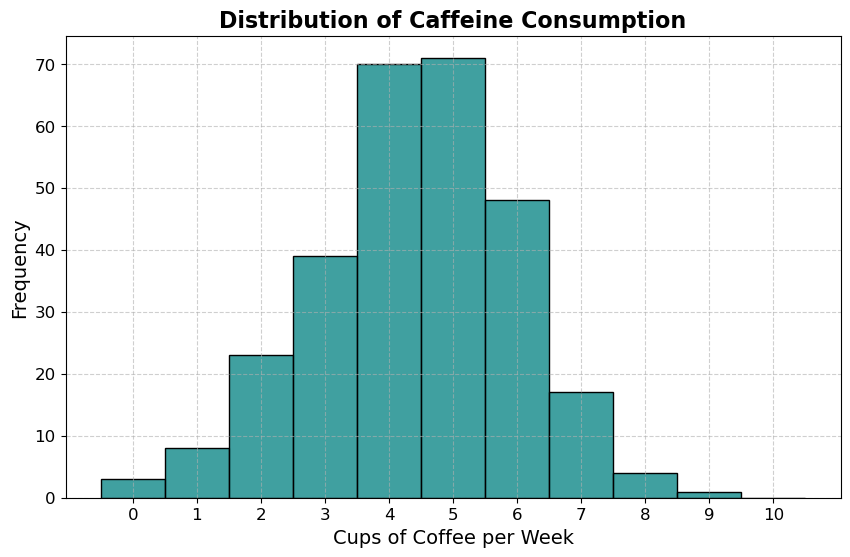

In [ ]:
# Remove NA vals
annotations['CaffeineConsumption'] = annotations['CaffeineConsumption'].replace(-1, np.nan)
annotations = annotations.dropna(subset=["CaffeineConsumption"])

# Histogram of Caffeine Consumption with custom bins
plt.figure(figsize=(10, 6))
sns.histplot(
    data=annotations,
    x="CaffeineConsumption",
    bins=range(0, 12),
    color="teal",
    edgecolor="black"
)
plt.title("Distribution of Caffeine Consumption", fontsize=16, fontweight="bold")
plt.xlabel("Cups of Coffee per Week", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Adjust x-ticks to be in the center of each bin
bin_centers = [i + 0.5 for i in range(0, 11)]  # Center of each bin
plt.xticks(bin_centers, labels=range(0, 11), fontsize=12)

plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()


_Figure 1: Distribution of Caffeine Consumption_

### Bar Plot of Sex Distribution
Next, we assessed the sex distribution in the dataset. As shown in Figure 2, males and females are nearly equally represented, ensuring balanced demographic coverage in terms of sex.

C:\Users\julso\AppData\Local\Temp\ipykernel_341764\1628227129.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


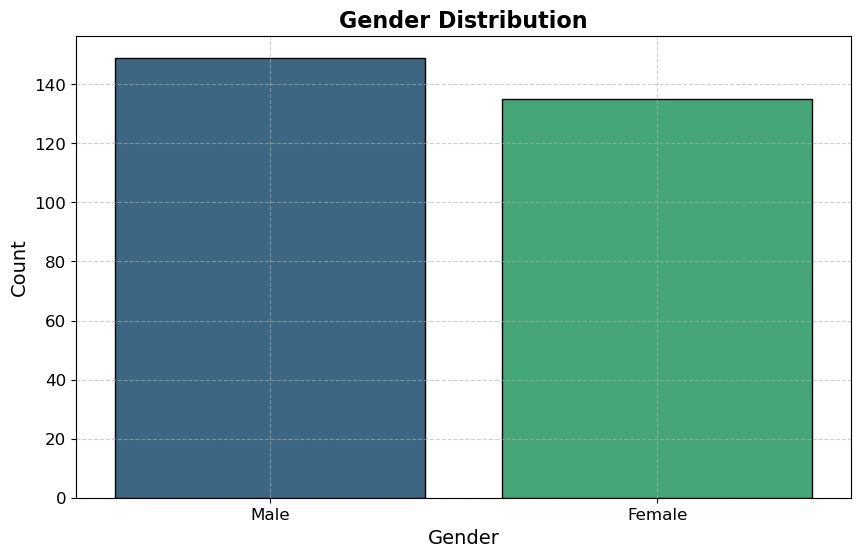

In [ ]:
# Bar Plot of Sex Distribution
plt.figure(figsize=(10, 6))
gender_counts = annotations['isFemale'].value_counts()
sns.barplot(
    x=["Male", "Female"],
    y=gender_counts.values,
    palette="viridis",
    edgecolor="black",
)
plt.title("Distribution of Sex", fontsize=16, fontweight="bold")
plt.xlabel("Sex", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()


_Figure 2: Distribution of Sex_

## 2. SNP-Level Filtering: Call Rate

The call rate for a given SNP is defined as the proportion of samples in the dataset for which the SNP's genotype information is not missing. The call rate provides a measure of data quality, where higher call rates indicate higher data completeness. It is calculated as:

$ \text{Call rate for SNP}_{i} = \frac{\text{Number of Samples with Genotype Data for SNP}_{i}}{\text{Total number of samples}} $

### Histogram of SNP Call Rates
​
The histogram (Figure 3) shows that most SNPs have call rates near 1.0, suggesting that the dataset is generally complete. However, a small fraction of SNPs exhibit lower call rates, reflecting missing genotype data. The logarithmic scale highlights the frequency of SNPs with call rates below 0.98.  


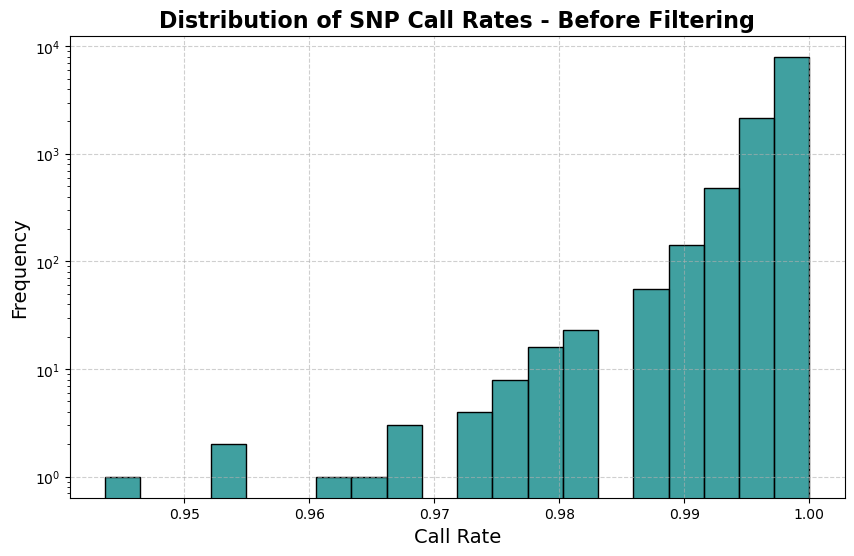

In [ ]:
# Identify genotype columns (everything after the metadata columns)
genotype_columns = vcf_data.columns[9:]  # Columns with genotype data 

# Calculate call rate for each SNP (row-wise)
call_rate = vcf_data[genotype_columns].apply(lambda row: (row != './.').sum() / len(row), axis=1)

# Plot the distribution of call rates
plt.figure(figsize=(10, 6))
sns.histplot(call_rate, bins=20, color="teal", edgecolor="black")
plt.title("Distribution of SNP Call Rates - Before Filtering", fontsize=16, fontweight="bold")
plt.xlabel("Call Rate", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.yscale("log") 
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

_Figure 3: Distribution of SNP Call Rates - Before Filtering_

To ensure high data quality, SNPs with incomplete data (call rate < 1.0) were removed. The filtering results are as follows:

In [45]:
# Filter SNPs with a call rate of 100%
high_quality_snps = call_rate[call_rate == 1.0]
vcf_data_SNP = vcf_data.loc[high_quality_snps.index, :]

# Report the number of removed variants
removed_variants = vcf_data.shape[0] - vcf_data_SNP.shape[0]
print(f"Number of SNPs removed due to low call rate: {removed_variants}")

# Check the shape of the filtered VCF matrix
print(f"Original number of SNPs: {vcf_data.shape[0]}")
print(f"Number of SNPs after filtering: {vcf_data_SNP.shape[0]}")

Number of SNPs removed due to low call rate: 2888
Original number of SNPs: 10879
Number of SNPs after filtering: 7991


This step removed about 26.6% of SNPs from the dataset. By retaining only SNPs with complete genotype data, we enhance the reliability of subsequent analyses.

## 3. SNP-level filtering: minor allele frequency (MAF)
The Minor Allele Frequency (MAF) represents the proportion of the least common allele (minor allele) at a given SNP across all samples. Rare variants with very low MAFs can introduce noise which in turn reduces the power of statistical tests, which is why variants with MAF ≤ 1% are typically excluded to ensure reliable analyses. It is calculated as: 

$ MAF = min( \frac{\text{Number of minor alleles}}{\text{Total alleles}}, \frac{\text{Number of major alleles}}{\text{Total alleles}})$

### Histogram of MAF Before Filtering

Similarly as before, we start by studying the distribution of MAFs. The histogram in Figure 4 shows that SNPs with higher MAFs are evenly distributed between 0.1 and 0.5. This distribution highlights the presence of a substantial number of rare variants, which are candidates for removal in the filtering process.

C:\Users\julso\AppData\Local\Temp\ipykernel_341764\3016214789.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vcf_data_SNP[genotype_columns] = vcf_data_SNP[genotype_columns].replace(gt_mapping)


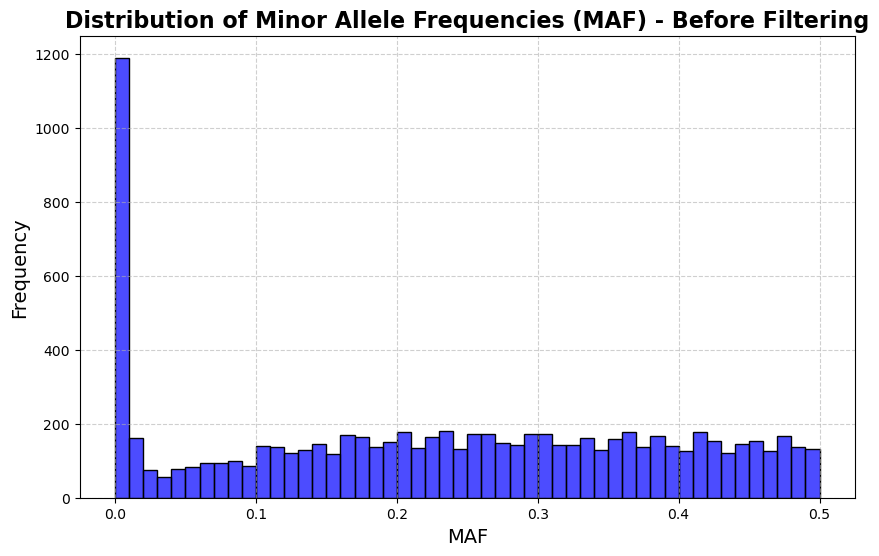

In [46]:
# Define genotype columns and map genotypes to numeric values
genotype_columns = vcf_data_SNP.columns[9:]
gt_mapping = {"./.": np.nan, ".|.": np.nan, "0/0": 0, "0/1": 1, "1/0": 1, "1/1": 2, "1|1": 2, "0|1": 1, "1|0": 1}
vcf_data_SNP[genotype_columns] = vcf_data_SNP[genotype_columns].replace(gt_mapping)

# Calculate MAF using vectorized operations
alt_allele_count = vcf_data_SNP[genotype_columns].sum(axis=1)
total_alleles = 2 * vcf_data_SNP[genotype_columns].notna().sum(axis=1)
alt_allele_freq = alt_allele_count / total_alleles
ref_allele_freq = 1 - alt_allele_freq
maf = pd.concat([alt_allele_freq, ref_allele_freq], axis=1).min(axis=1)

# Drop SNPs with NaN MAF values (no valid genotype data)
maf = maf.dropna()

# Plot histogram of MAF before filtering
plt.figure(figsize=(10, 6))
sns.histplot(maf, bins=50, color="blue", edgecolor="black", alpha=0.7)
plt.title("Distribution of Minor Allele Frequencies (MAF) - Before Filtering", fontsize=16, fontweight="bold")
plt.xlabel("MAF", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

_Figure 4: Distribution Minor Allele Frequencies (MAFs) - Before Filtering_

To improve data quality, SNPs with MAF ≤ 1% were removed. The results of this filtering step are:

In [47]:
# Filter SNPs with MAF > 1%
maf_threshold = 0.01
high_maf_indices = maf[maf > maf_threshold].index

# Retain all columns for the filtered SNPs
vcf_data_cleaned = vcf_data_SNP.loc[high_maf_indices, :]

# Report results
removed_variants = len(maf) - len(high_maf_indices)
print(f"Number of SNPs removed due to low MAF: {removed_variants}")
print(f"Original number of SNPs: {len(maf) + removed_variants}")
print(f"Number of SNPs after filtering: {vcf_data_cleaned.shape[0]}")

Number of SNPs removed due to low MAF: 1189
Original number of SNPs: 9180
Number of SNPs after filtering: 6802


This filtering step removed approximately 14.9% of SNPs, ensuring that subsequent analyses focus on variants with sufficient allele frequencies for meaningful statistical tests.

##  4. Genome-Wide Association Studies

To investigate whether sex influences caffeine consumption, we visualized the distribution of caffeine intake across males and females using three plots: a boxplot, a density plot, and a count plot.

### Boxplot of Caffeine Consumption by Sex

The boxplot displays the distribution of caffeine consumption for males and females. We see minor differences in consumption patterns, as the median caffeine consumption is slightly higher for males than for females. However, the interquartile ranges (IQRs) are similar between sexes.  

C:\Users\julso\AppData\Local\Temp\ipykernel_341764\1151364468.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=annotations, x="isFemale", y="CaffeineConsumption", palette="pastel")


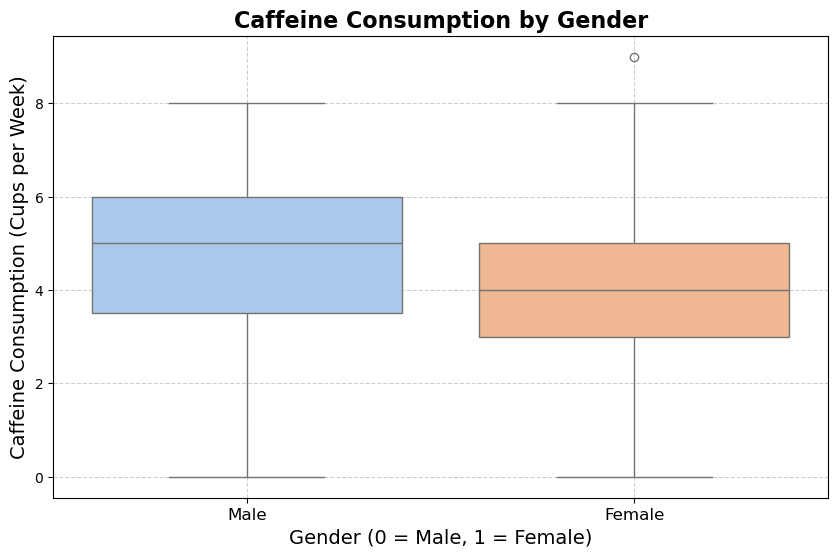

In [ ]:
# Boxplot of caffeine consumption by sex
plt.figure(figsize=(10, 6))
sns.boxplot(data=annotations, x="isFemale", y="CaffeineConsumption", palette="pastel")
plt.title("Caffeine Consumption by Sex", fontsize=16, fontweight="bold")
plt.xlabel("Sex (0 = Male, 1 = Female)", fontsize=14)
plt.ylabel("Caffeine Consumption (Cups per Week)", fontsize=14)
plt.xticks([0, 1], ["Male", "Female"], fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

_Figure 5: Boxplot of Caffeine Consumption by Sex_

### Density Plot (KDE) of Caffeine Consumption by Sex

A smoothed density plot of caffeine consumption shows that the distributions for males and females are nearly identical, with peaks around 4–5 cups per week. Note that increasing the bandwidth in the KDE plot improved smoothness, but slight negative values appear due to kernel density estimation, which obviously do not represent actual data points as negative caffeine consumption is not possible. Despite this, the overall trend remains interpretable.

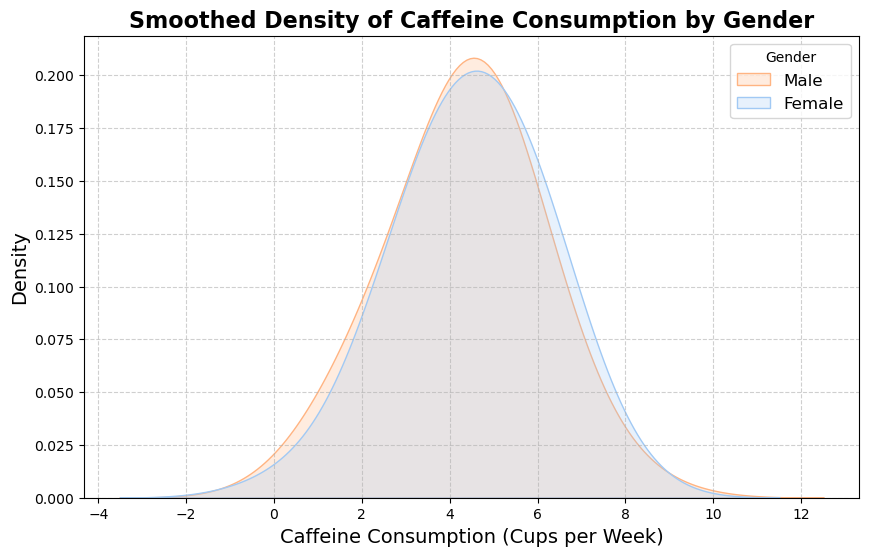

In [ ]:
# Density plot with KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    fill=True,
    common_norm=False,
    palette="pastel",
    bw_adjust=2  # Increased the bandwidth to make it smoother (default is 1)
)
plt.title("Smoothed Density of Caffeine Consumption by Sex", fontsize=16, fontweight="bold")
plt.xlabel("Caffeine Consumption (Cups per Week)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(labels=["Male", "Female"], title="Sex", fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

_Figure 6: Smoothed Density of Caffeine Consumption by Sex_

### Count Plot of Caffeine Consumption by Sex

While not specifically requested in the task, the count plot offers another perspective on the differences in caffeine consumption, and is easier to interpret compared to the KDE plot. Figure 7 shows that females tend to dominate the middle range, particularly around 4–5 cups per week, while males show slightly higher counts at the extremes.

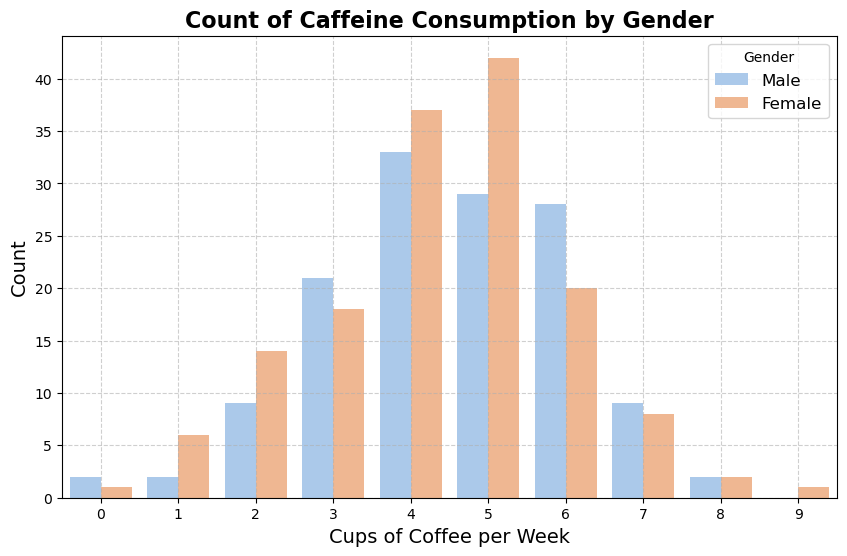

In [ ]:
# Countplot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    palette="pastel"
)
plt.title("Count of Caffeine Consumption by Sex", fontsize=16, fontweight="bold")
plt.xlabel("Cups of Coffee per Week", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Sex", labels=["Male", "Female"], fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()


_Figure 7: Count of Caffeine Consumption by Sex_

### Linear regression analysis
To quantify the impact of sex on caffeine consumption, a simple linear regression model was fitted using sex ($isFemale$) as the independent variable and weekly caffeine consumption as the dependent variable. The model's coefficients and the coefficient of determination ($R^2$) were studied to evaluate the relationship and assess the need to include sex as a covariate. The results and summary of the linear regression fit are as follows:

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data for regression
X = annotations['isFemale'].astype(int).values.reshape(-1, 1)  # Convert to numeric and reshape
y = annotations['CaffeineConsumption']

# Fit the linear regression model
reg = LinearRegression().fit(X, y)

# Extract regression results
r_squared = reg.score(X, y)  # R^2 value
coef = reg.coef_[0]  # Slope (coefficient for isFemale)
intercept = reg.intercept_  # Intercept

# Print results
print(f"R-squared: {r_squared}")
print(f"Intercept: {intercept}")
print(f"Coefficient (Gender; Female = 1): {coef}")



R-squared: 0.002376415301229895
Intercept: 4.496296296296296
Coefficient (Gender; Female = 1): -0.15401441710166544


Note that: 

* The $R^2$ value, which represents the proportion of variance in caffeine consumption explained by sex, is negligibly small, which shows that sex has almost no explanatory power for caffeine consumption.

* The intercept ($\beta_0$) reflects the average caffeine consumption for males (sex = 0), approximately 3.99 cups per week.

* The coefficient ($\beta_1$) suggests that females (sex = 1) consume, on average, 0.012 fewer cups of coffee per week than males. However, this difference is negligible and statistically non-significant ($p=0.829$), which means that any observed differences in caffeine consumption between males and females are likely due to random variation rather than a true effect.

Based on these results, although the plots showed that there are differences in caffeine consumption by sex, it has almost no explanatory power when we fit the simple linear regression model. Thus sex is unlikely to be a meaningful covariate for explaining caffeine consumption. While sex does not explain variation in caffeine consumption, there is the possibility of other covariates, such as ethnicity (superpopulation), influencing the phenotype.

### Population Structure Analysis Using PCA

To account for potential population stratification, PCA was performed on the genotype matrix. By visualizing the first two principal components (PC1 and PC2), the goal is to identify potential clusters and determine whether correcting for population structure is necessary for the GWAS.

The PCA plot below shows five distinct clusters, corresponding to the superpopulations (EUR, EAS, AFR, AMR, SAS). These clusters are well-separated, indicating that genetic variation is strongly associated with ancestry.

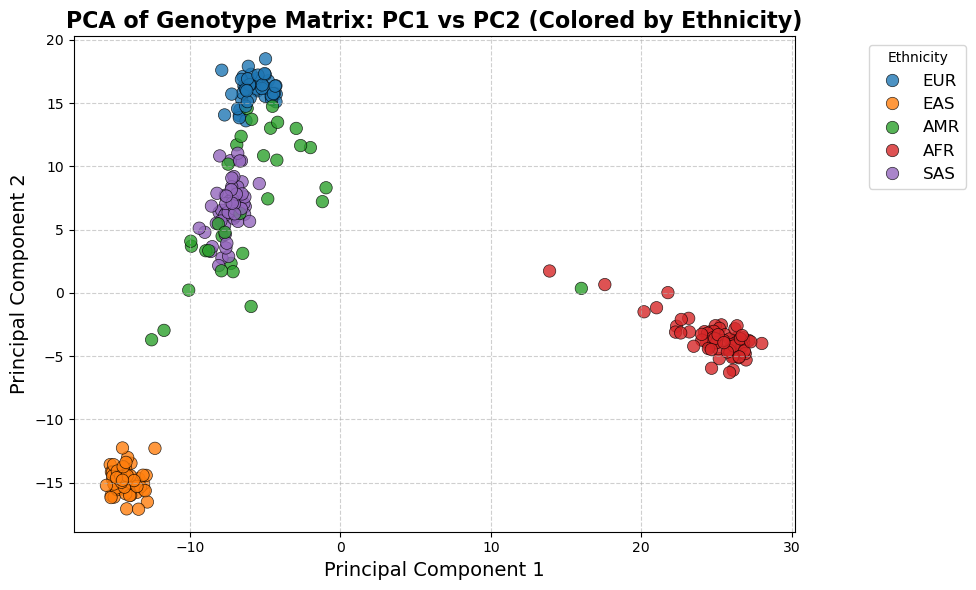

In [ ]:
# Transpose so that samples are rows and SNPs are columns
df_for_pca_numeric = vcf_data_cleaned[vcf_data_cleaned.columns[9:]].T

# Confirm the data type is numerical, think this can be removed
df_for_pca_numeric = df_for_pca_numeric.apply(pd.to_numeric)

# Initialize PCA with three components
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_for_pca_numeric)

# Convert PCA results to a DataFrame
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'], index=df_for_pca_numeric.index)


# Merge PCA results with annotations
pca_df = pca_df.join(annotations[['SuperPopulation']])

# Plot PC1 vs. PC2 colored by ethnicity
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='SuperPopulation',  # Color by SuperPopulation (ethnicity)
    palette="tab10",  # Use distinct colors
    alpha=0.8,
    s=80,  # Increase point size for better visibility
    edgecolor="k",  # Add black edges for contrast
    linewidth=0.5  # Thin edges
)
plt.title("PCA of Genotype Matrix: PC1 vs PC2 (Colored by Ethnicity)", fontsize=16, fontweight="bold")
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.legend(title="Ethnicity", fontsize=12, loc="upper right", bbox_to_anchor=(1.25, 1))
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


_Figure 8: PCA of Genotype Matrix: PC1 vs PC2 (Colored by Ethnicity)_

To evaluate the potential role of ancestry (superpopulation) in shaping caffeine consumption behavior, we analyzed mean caffeine consumption levels across superpopulations, using both confidence interval and box plots.

Figure 9 shows the mean caffeine consumption for each superpopulation alongside 95% confidence intervals. The lack of complete overlap between some confidence intervals, particularly for AMR versus AFR or EAS, hints at meaningful differences in average caffeine consumption between superpopulations.

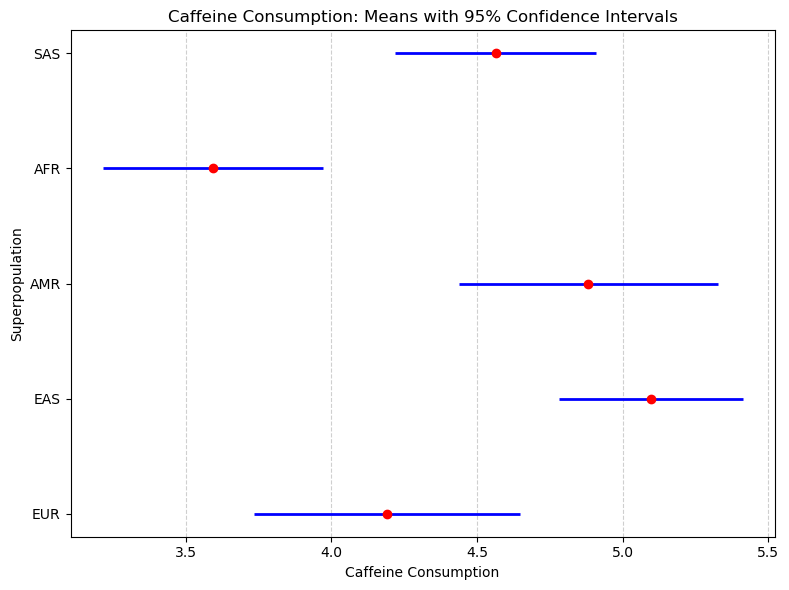

In [ ]:
# Superpopulations of interest
superpops = annotations['SuperPopulation'].unique()

# Extract means, standard deviations, and sample sizes from annotations
means = []
stds = []
sample_sizes = []

for superpop in superpops:
    data = annotations['CaffeineConsumption'][annotations['SuperPopulation'] == superpop]
    means.append(data.mean())
    stds.append(data.std())
    sample_sizes.append(len(data))

# Confidence level (95%)
z = 1.96

# Calculate CIs
cis = [z * (std / np.sqrt(n)) for std, n in zip(stds, sample_sizes)]

# Calculate lower and upper bounds for the CIs
ci_lower = [mean - ci for mean, ci in zip(means, cis)]
ci_upper = [mean + ci for mean, ci in zip(means, cis)]

# Plot horizontal lines
plt.figure(figsize=(8, 6))
y_positions = np.arange(len(superpops))

for y, lower, upper, mean in zip(y_positions, ci_lower, ci_upper, means):
    plt.hlines(y, lower, upper, colors='blue', lw=2)  # Horizontal lines for CIs
    plt.plot(mean, y, 'o', color='red')  # Mark the mean

# Add labels and titles
plt.yticks(y_positions, superpops)
plt.xlabel('Caffeine Consumption')
plt.ylabel('Superpopulation')
plt.title('Caffeine Consumption: Means with 95% Confidence Intervals')

# gridlines 
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


_Figure 9: Confidence Interval Plot of Mean Caffeine Consumption_

The boxplot in Figure 10 provides a deeper look at the distribution of caffeine consumption within each superpopulation. Again, the differences in medians and overall distributions highlight the potential role of ancestry in shaping consumption patterns.

C:\Users\julso\AppData\Local\Temp\ipykernel_341764\3724222005.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


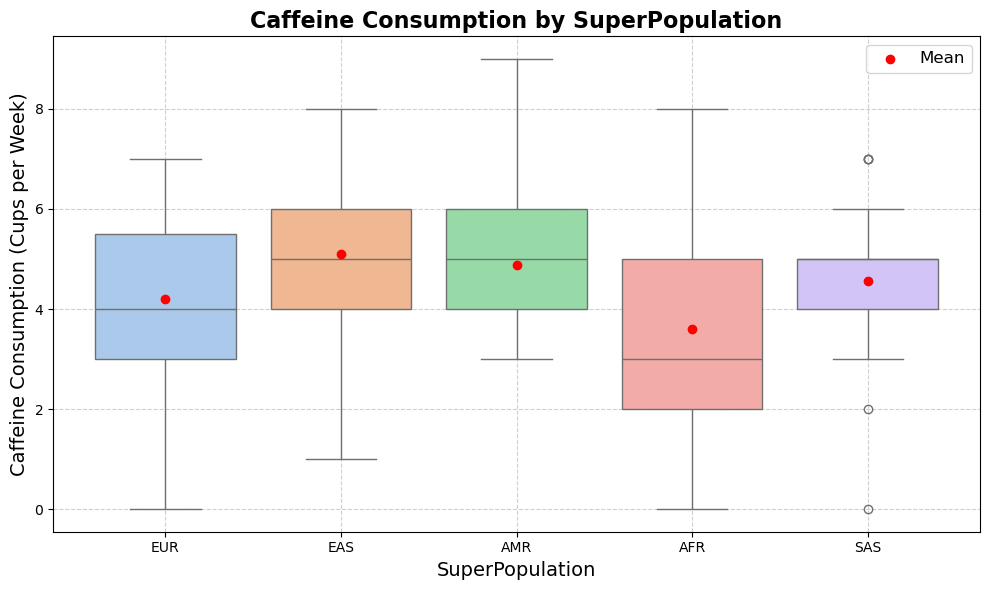

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=annotations,
    x="Superpopulation",
    y="CaffeineConsumption",
    palette="pastel",
    showfliers=True
)

# Calculate means for each SuperPopulation
means = annotations.groupby('SuperPopulation')['CaffeineConsumption'].mean()

# Overlay mean points
plt.scatter(x=means.index, y=means.values, color="red", label="Mean", zorder=10)

plt.title("Caffeine Consumption by Superpopulation", fontsize=16, fontweight="bold")
plt.xlabel("SuperPopulation", fontsize=14)
plt.ylabel("Caffeine Consumption (Cups per Week)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


_Figure 10: Boxplot of Caffeine Consumption by SuperPopulation_

Based on these findings, correcting for population structure would be sensible since the PCA revealed significant genetic variation across populations, with distinct ancestry-related clusters. Without correction, GWAS risks identifying loci tied to ancestry rather than caffeine consumption. Including PCs as covariates accounts for this bias, ensuring the results reflect genetic factors genuinely associated with caffeine consumption. 

## GWAS Without Covariates

To test for the association between genetic variants and caffeine consumption, linear regression models were fitted separately for each variant. The methodology is as follows: 
* Genotype data for 6,802 variants was combined with caffeine consumption data.
* Variants were analyzed using linear regression, with genotype as the predictor and caffeine consumption as the response.
* $\beta$-coefficients and p-values were recorded.

In [55]:
# Extract sample IDs from the VCF data (columns starting from index 9)
sample_columns = vcf_data_cleaned.columns[9:]

# Initialize lists to store results
variant_ids = []
beta_coefficients = []
p_values = []

# Loop over each variant in the VCF data
for idx in vcf_data_cleaned.index:
    # Construct a unique variant ID using 'CHROM' and 'POS'
    chrom = vcf_data_cleaned.loc[idx, 'CHROM']
    pos = vcf_data_cleaned.loc[idx, 'POS']
    variant_id = f"{chrom}:{pos}"
    
    # Get genotypes for all samples for this variant
    genotypes = vcf_data_cleaned.loc[idx, sample_columns]
    
    # Create a DataFrame with sample IDs and genotypes
    genotype_df = pd.DataFrame({
        'Sample': sample_columns,
        'Genotype': genotypes.values
    })
    
    # Set 'Sample' as the index to match with annotations
    genotype_df.set_index('Sample', inplace=True)
    
    # Merge genotype data with phenotype data
    merged_df = genotype_df.join(annotations[['CaffeineConsumption']], how='inner')
    
    # Drop rows with missing data
    merged_df.dropna(subset=['Genotype', 'CaffeineConsumption'], inplace=True)
    
    # Convert data to numeric
    merged_df['Genotype'] = pd.to_numeric(merged_df['Genotype'], errors='coerce')
    merged_df['CaffeineConsumption'] = pd.to_numeric(merged_df['CaffeineConsumption'], errors='coerce')
    
    # Drop any rows with NaN values after conversion
    merged_df.dropna(subset=['Genotype', 'CaffeineConsumption'], inplace=True)
    
    # Prepare the data for regression
    X = merged_df['Genotype']
    y = merged_df['CaffeineConsumption']
    
    # Add a constant term for the intercept
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Extract the beta coefficient and p-value for 'Genotype'
    beta = model.params['Genotype']
    p_value = model.pvalues['Genotype']
    
    # Store the results
    variant_ids.append(variant_id)
    beta_coefficients.append(beta)
    p_values.append(p_value)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'VariantID': variant_ids,
    'Beta': beta_coefficients,
    'PValue': p_values
})

# Display the results
print(results_df)


        VariantID      Beta    PValue
0        1:904165 -0.151826  0.432593
1       1:1707740  0.127177  0.442795
2       1:2284195  0.197424  0.147315
3       1:2779043 -0.207420  0.103468
4       1:2944527  0.093034  0.567858
...           ...       ...       ...
6797  X:140993264  0.090086  0.564411
6798  X:141689987 -0.187803  0.394500
6799  X:145128805  0.035973  0.767421
6800  X:146758895 -0.496086  0.000120
6801  X:152091153 -0.036831  0.771978

[6802 rows x 3 columns]


The results of the linear regression models are: 
* Most $\beta$-values are small, indicating minor effects on caffeine consumption.
* Few variants (e.g., X:146758895, p=0.00012) show significant associations, while most are non-significant.
Including covariates may help address potential confounding factors and refine these results.

### Manhattan Plot of GWAS Results without Covariates
A Manhattan plot was generated to visualize the genome-wide association results. Each point represents a variant, with its genomic position on the x-axis and the significance of association $-log_{10}(\text{p-value})$ on the y-axis. A Bonferroni-corrected significance threshold was included to highlight significant variants.

The plot shows that only a few variants surpass the Bonferroni-corrected threshold, and these are scattered across the genome without any clear clustering. Most variants show no significant association, with $-log_{10}(\text{p-values})$ falling below the threshold. The scattered distribution of significant variants suggests potential confounding factors, such as uncorrected population structure.

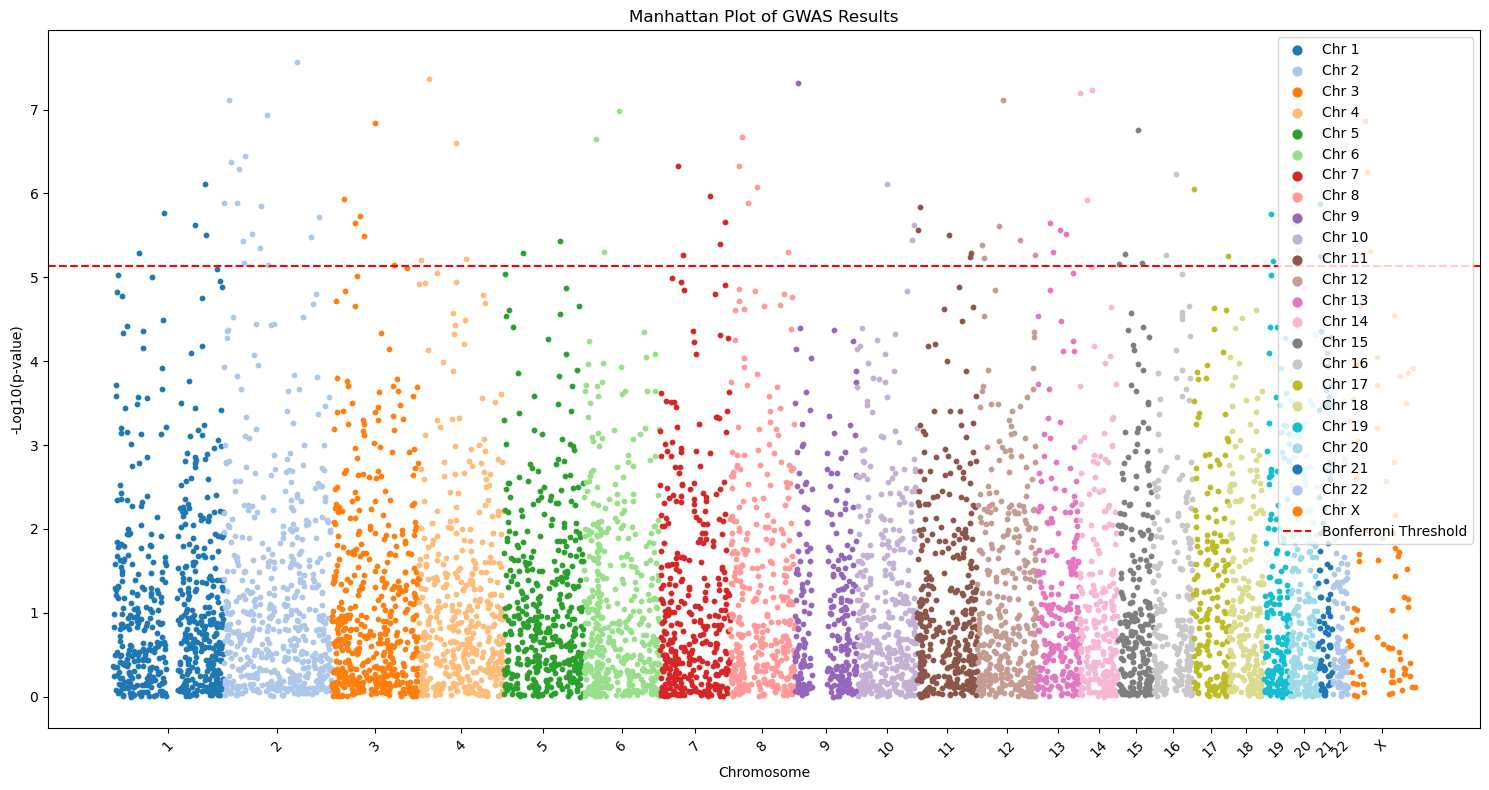

In [ ]:
def preprocess_results_df(df):
    # Split VariantID into CHR and BP
    df[['CHR', 'BP']] = df['VariantID'].str.split(':', expand=True)
    df['BP'] = df['BP'].astype(int)  # Ensure BP is numeric
    
    # Map chromosomes to integers (X to 23)
    chromosome_mapping = {str(i): i for i in range(1, 23)}  # Chromosomes 1-22
    chromosome_mapping.update({'X': 23}) 
    df['CHR'] = df['CHR'].map(chromosome_mapping)  # Map CHR to integers
    
    # Calculate -log10(PValue)
    df['minus_log10_pvalue'] = -np.log10(df['PValue'])
    
    return df

results_df = preprocess_results_df(results_df)

def calculate_cumulative_bp(df):
    cumulative_bp = 0
    chromosome_ticks = []
    chromosome_labels = []
    cumulative_bp_col = []

    for chrom in sorted(df['CHR'].unique()):
        chrom_data = df[df['CHR'] == chrom]
        min_bp = chrom_data['BP'].min()
        max_bp = chrom_data['BP'].max()
        chrom_range = max_bp - min_bp

        # Adjust positions
        adjusted_bp = chrom_data['BP'] + cumulative_bp - min_bp
        cumulative_bp_col.extend(adjusted_bp)

        # Add ticks and labels
        middle = cumulative_bp + (chrom_range / 2)
        chromosome_ticks.append(middle)
        chromosome_labels.append(str(chrom) if chrom <= 22 else 'X')

        # Update cumulative_bp with buffer
        cumulative_bp += chrom_range + 1e6  # 1Mb buffer

    df['cumulative_BP'] = cumulative_bp_col
    return df, chromosome_ticks, chromosome_labels



def plot_manhattan(df, chromosome_ticks, chromosome_labels, bonferroni_threshold):
    plt.figure(figsize=(15, 8))

    # Replace chromosome number 23 with "X" for proper naming
    df['CHR'] = df['CHR'].replace({23: "X"})

    # Sort chromosomes: numeric ones first, followed by "X" if present
    unique_chromosomes = sorted(
        df['CHR'].unique(),
        key=lambda x: (int(x) if str(x).isdigit() else float('inf'), x)
    )
    palette = sns.color_palette("tab20", n_colors=len(unique_chromosomes))

    for i, chrom in enumerate(unique_chromosomes):
        chrom_data = df[df['CHR'] == chrom]
        plt.scatter(
            chrom_data['cumulative_BP'],
            chrom_data['minus_log10_pvalue'],
            c=[palette[i]],
            s=10,
            label=f'Chr {chrom}'
        )

    # Add Bonferroni threshold line
    plt.axhline(y=bonferroni_threshold, color='red', linestyle='--', label='Bonferroni Threshold')

    # Labels and ticks
    plt.xlabel('Chromosome')
    plt.ylabel('-Log10(p-value)')
    plt.title('Manhattan Plot of GWAS Results without Covariates')
    plt.xticks(chromosome_ticks, chromosome_labels, rotation=45)

    # Unique legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), markerscale=2)

    plt.tight_layout()
    plt.show()

# Calculate cumulative positions
results_df, ticks, labels = calculate_cumulative_bp(results_df)

# Define Bonferroni threshold
bonferroni_threshold = -np.log10(0.05 / len(results_df))

# Plot Manhattan plot
plot_manhattan(results_df, ticks, labels, bonferroni_threshold)

_Figure 11: Manhattan Plot of GWAS Results without Covariates_

## GWAS with Population Structure Correction
The GWAS was repeated with the top 10 principal components (PCs) as covariates to account for population structure. A Manhattan plot was generated to compare these results with the uncorrected analysis.

### Manhattan Plot of GWAS Results with Population Structure Correction
The plot shows that the overall distribution of significant $-log_{10}(\text{p-values})$ has changed with respect to the GWAS with no covariates, now significant variants are concentrated around loci on chromosome 8. Fewer variants exceed the Bonferroni threshold compared to the uncorrected GWAS. Significant variants are more concentrated, reducing the appearance of random, scattered associations seen previously. After correction, most previously significant SNPs no longer pass the threshold, indicating they were likely false positives caused by confounding. The remaining significant associations are more likely to reflect genuine genetic influences.

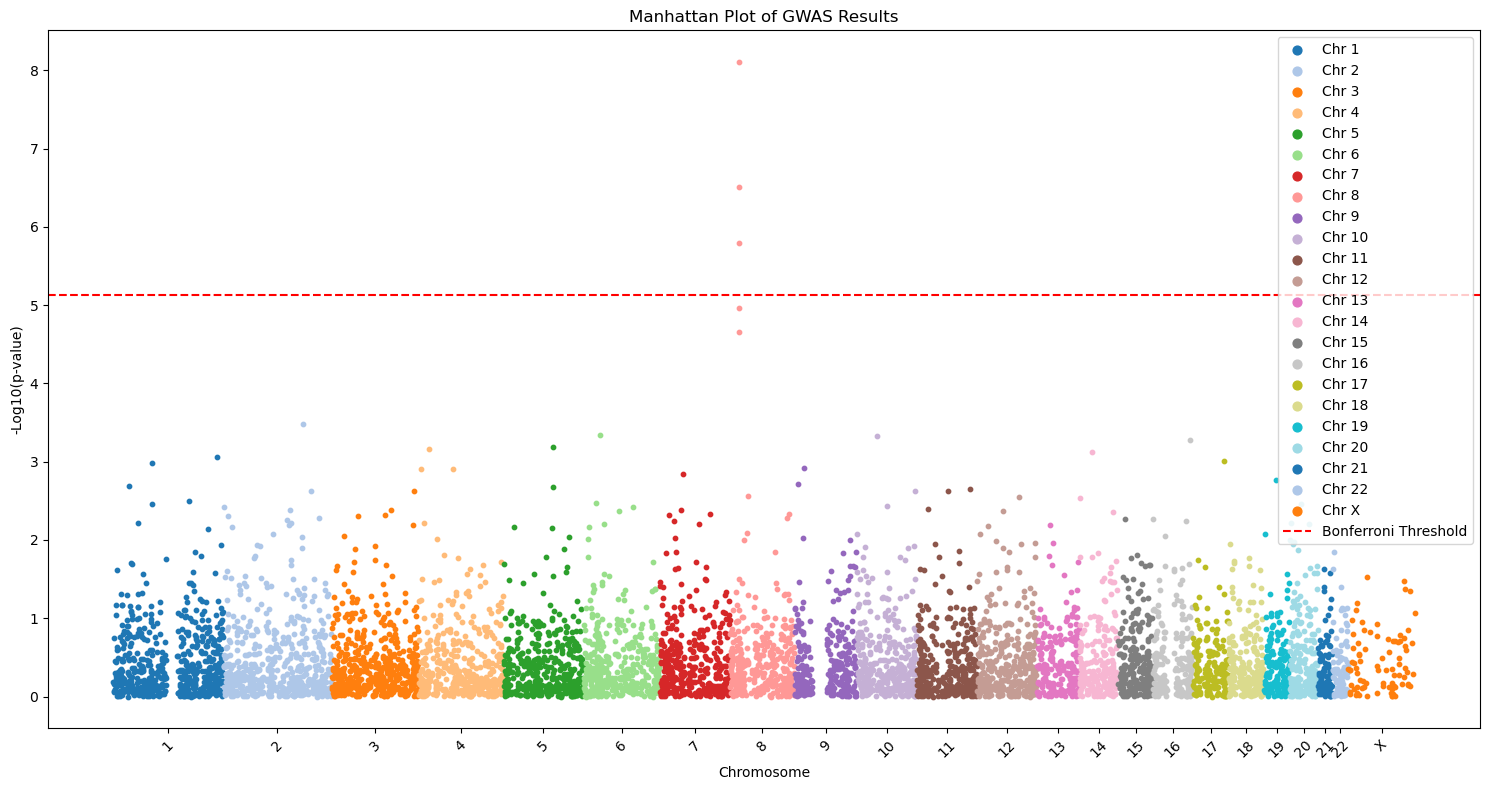

Significant variants:
Chromosome: 8, Position: 19600329
Chromosome: 8, Position: 19619751
Chromosome: 8, Position: 19651161


In [57]:
# Transpose the SNP matrix for PCA (samples as rows, SNPs as columns)
df_for_pca_numeric = vcf_data_cleaned.iloc[:, 9:].T  
df_for_pca_numeric = df_for_pca_numeric.apply(pd.to_numeric, errors='coerce') 

# Perform PCA with 10 components
pca = PCA(n_components=10)
top_10_pcs = pca.fit_transform(df_for_pca_numeric)  # Shape: (samples, 10)
pca_df = pd.DataFrame(top_10_pcs, columns=[f'PC{i+1}' for i in range(10)], index=df_for_pca_numeric.index)

phenotypes = annotations['CaffeineConsumption']

# GWAS with PCs as covariates
gwas_results = []
for idx in vcf_data_cleaned.index:
    # Extract SNP genotypes
    genotypes = vcf_data_cleaned.loc[idx, vcf_data_cleaned.columns[9:]].T
    genotypes = pd.to_numeric(genotypes, errors='coerce')
    
    # Prepare the design matrix (SNP + Top 10 PCs)
    X = pd.DataFrame({'SNP': genotypes}, index=pca_df.index)
    X = pd.concat([X, pca_df], axis=1)
    X = sm.add_constant(X)  # Add intercept
    
    # Ensure alignment with phenotype
    X = X.loc[X.index.intersection(phenotypes.index)]
    y = phenotypes.loc[X.index]

    if X['SNP'].isnull().any():
        continue  # Skip SNPs with missing genotypes
    
    # Fit linear regression
    model = sm.OLS(y, X).fit()
    
    # Extract p-value for the SNP
    p_value = model.pvalues.get('SNP', np.nan)
    if not pd.isna(p_value):
        gwas_results.append({
            'VariantID': f"{vcf_data_cleaned.loc[idx, 'CHROM']}:{vcf_data_cleaned.loc[idx, 'POS']}",
            'PValue': p_value
        })

# Create DataFrame with GWAS results
updated_results_df = pd.DataFrame(gwas_results)
updated_results_df['minus_log10_pvalue'] = -np.log10(updated_results_df['PValue'])

# Recalculate Bonferroni Threshold
bonferroni_threshold = -np.log10(0.05 / len(updated_results_df))

# Plot the Manhattan Plot
# Preprocess results DataFrame for plotting
results_df = preprocess_results_df(updated_results_df)
results_df, ticks, labels = calculate_cumulative_bp(results_df)

# Plot
plot_manhattan(results_df, ticks, labels, bonferroni_threshold)

# Identify significant variants
significant_variants = updated_results_df[updated_results_df['minus_log10_pvalue'] > bonferroni_threshold]

# Print significant variant locations (chromosome and position)
print("Significant variants:")
for _, row in significant_variants.iterrows():
    print(f"Chromosome: {row['VariantID'].split(':')[0]}, Position: {row['VariantID'].split(':')[1]}")



_Figure 12: Manhattan Plot of GWAS Results with Top Ten PCs as covariates_

## GWAS with Superpopulation as a Covariate
The GWAS was repeated using superpopulation (ethnicity) as a covariate instead of the top 10 principal components (PCs). The objective is to assess the impact of ethnicity on the results and compare this approach to PCA-based correction.

### Manhattan Plot of GWAS Results with Superpopulation as a Covariate
The plot shows that significant variants are concentrated around loci on chromosome 8, similar to the PCA-corrected GWAS. The overall distribution of $-log_{10}(\text{p-values})$ is consistent with the PCA approach, reinforcing that population structure correction effectively reduces false positives.

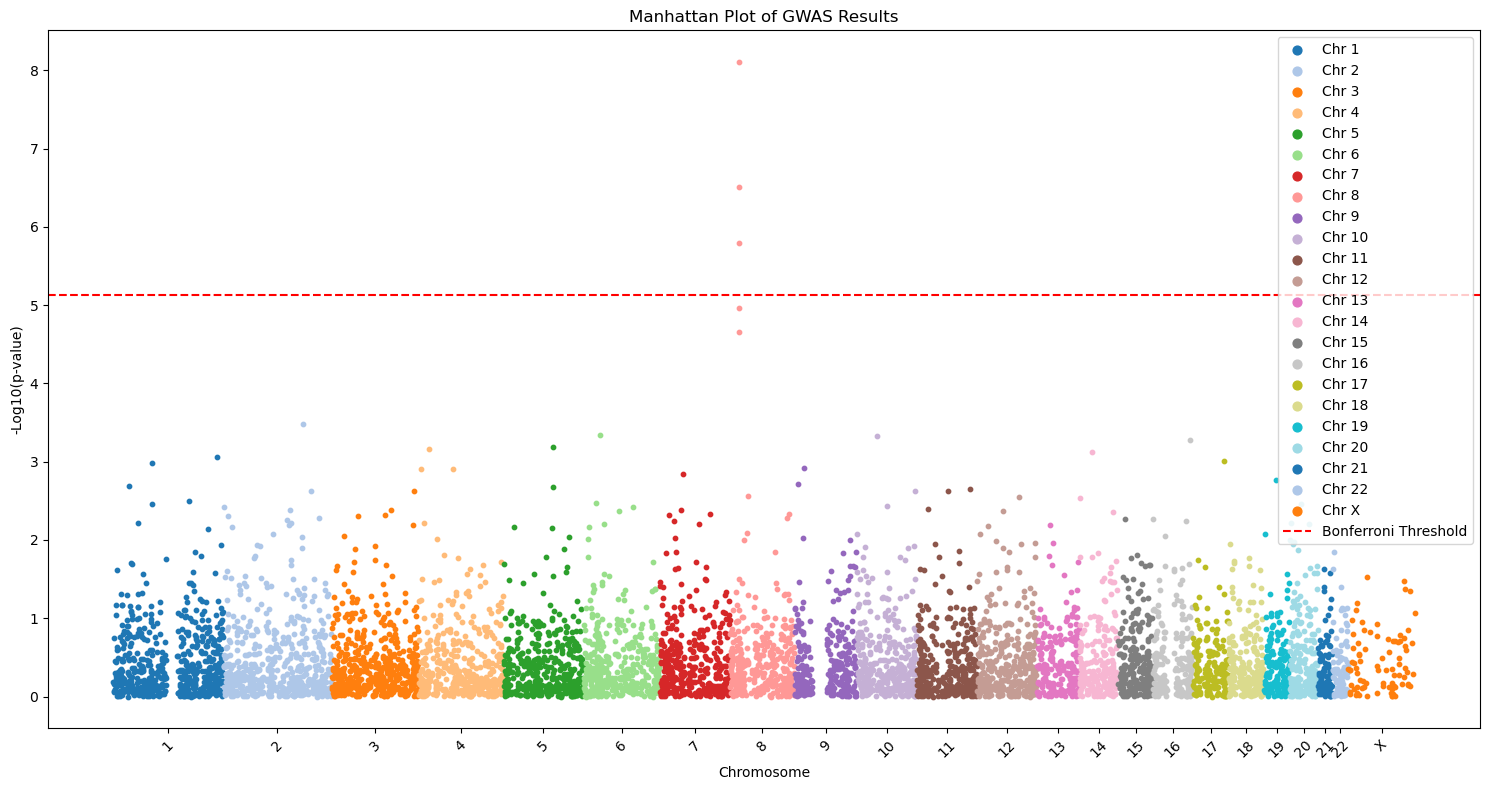

Significant variants:
Chromosome: 8, Position: 19600329
Chromosome: 8, Position: 19619751
Chromosome: 8, Position: 19651161


In [ ]:
# Transpose the SNP matrix (samples as rows, SNPs as columns)
df_for_pca_numeric = vcf_data_cleaned.iloc[:, 9:].T  
df_for_pca_numeric = df_for_pca_numeric.apply(pd.to_numeric, errors='coerce')  # Ensure numeric data

# Get dummies for the superpopulation
annotations_numeric = pd.get_dummies(annotations['SuperPopulation'], prefix='SuperPop').astype(int)

phenotypes = annotations['CaffeineConsumption']

# GWAS with SUperPop as covariates
gwas_results = []
for idx in vcf_data_cleaned.index:
    # Extract SNP genotypes
    genotypes = vcf_data_cleaned.loc[idx, vcf_data_cleaned.columns[9:]].T
    genotypes = pd.to_numeric(genotypes, errors='coerce')
    
    # Prepare the design matrix (SNP + SuperPopulation)
    X = pd.DataFrame({'SNP': genotypes}, index=annotations_numeric.index)
    X = pd.concat([X, pca_df], axis=1)
    X = sm.add_constant(X)  # Add intercept
    
    # Ensure alignment with phenotype
    X = X.loc[X.index.intersection(phenotypes.index)]
    y = phenotypes.loc[X.index]

    if X['SNP'].isnull().any():
        continue  # Skip SNPs with missing genotypes
    
    # Fit linear regression
    model = sm.OLS(y, X).fit()
    
    # Extract p-value for the SNP
    p_value = model.pvalues.get('SNP', np.nan)
    if not pd.isna(p_value):
        gwas_results.append({
            'VariantID': f"{vcf_data_cleaned.loc[idx, 'CHROM']}:{vcf_data_cleaned.loc[idx, 'POS']}",
            'PValue': p_value
        })

# Create DataFrame with GWAS results
updated_results_df = pd.DataFrame(gwas_results)
updated_results_df['minus_log10_pvalue'] = -np.log10(updated_results_df['PValue'])

# Recalculate Bonferroni Threshold
bonferroni_threshold = -np.log10(0.05 / len(updated_results_df))

# Preprocess results DataFrame for plotting
results_df = preprocess_results_df(updated_results_df)
results_df, ticks, labels = calculate_cumulative_bp(results_df)

# Plot Manhattan
plot_manhattan(results_df, ticks, labels, bonferroni_threshold)

# Identify significant variants
significant_variants = updated_results_df[updated_results_df['minus_log10_pvalue'] > bonferroni_threshold]

# Print significant variant locations (chromosome and position)
print("Significant variants:")
for _, row in significant_variants.iterrows():
    print(f"Chromosome: {row['VariantID'].split(':')[0]}, Position: {row['VariantID'].split(':')[1]}")



_Figure 13: Manhattan Plot of GWAS Results with Superpopulation as a Covariate_

### Which approach to prefer?

When deciding between PCA and superpopulation as methods to control for population stratification, the choice depends on the strengths and limitations of each approach:

#### PCA:
* PCA captures continuous genetic variation, making it highly effective at accounting for subtle differences within and across populations. 
* The downside is that PCA can be harder to interpret. The principal components represent mathematical summaries of genetic variation, not easily tied to specific demographic or biological groups. 

#### Superpopulation:
* Using superpopulation as a covariate is straightforward and intuitive. The categories align with biological or demographic groupings, making results easier to explain.
* However, this method assumes clear boundaries between populations and may miss finer genetic differences within groups, which can leave residual confounding that PCA would otherwise address.

In conclusion, PCA is generally the better choice because it provides a more nuanced correction for population structure. While superpopulation may be sufficient in datasets with clear and distinct population categories, PCA is more versatile and robust for most GWAS applications.

## Functional Analysis 

Using the genomic coordinates Chromosome 8: Position 19600329 (GRCh37), the variant rs6983139 was identified through dbSNP (1). Further investigation on Open Targets Genetics revealed that the top associated gene linked to this SNP is CSGALNACT1 (Chondroitin Sulfate N-Acetylgalactosaminyltransferase 1).

This association is supported by multiple lines of evidence found on Open Targets Genetics (2):
* Extremely low P-values (e.g., 2.0e-10) suggest strong statistical significance of the association.
* A high Locus-to-Gene (L2G) prioritization score (e.g., 0.75–0.84) strengthens the evidence that CSGALNACT1 is a causal gene linked to the SNP. Promoter Capture Hi-C (PCHi-C) data, which identifies physical interactions between the SNP region and the CSGALNACT1 promoter, is integrated into the L2G scoring. This chromatin interaction evidence enhances confidence in the functional link between the variant and the gene.

## QQ Plot of GWAS P-Values
To evaluate the reliability of the GWAS results, a Q-Q plot was generated to compare observed p-values to the expected uniform distribution under the null hypothesis. Figure 14 shows that most of the observed p-values align closely with the diagonal $x=y$ line, which means that for the majority of genetic variants, the null hypothesis of no association holds true. The Q-Q plot highlights variants with exceptionally low p-values, corresponding to the highest peaks in the Manhattan plot. Points that deviate significantly upward from the $x=y$ line indicate true genetic associations rather than random variation. This deviation shows an excess of significant p-values compared to what would be expected under the null hypothesis.

By linking the Q-Q and Manhattan plots, we can confirm that the strongest associations are not spurious signals but represent genuine genetic associations. 


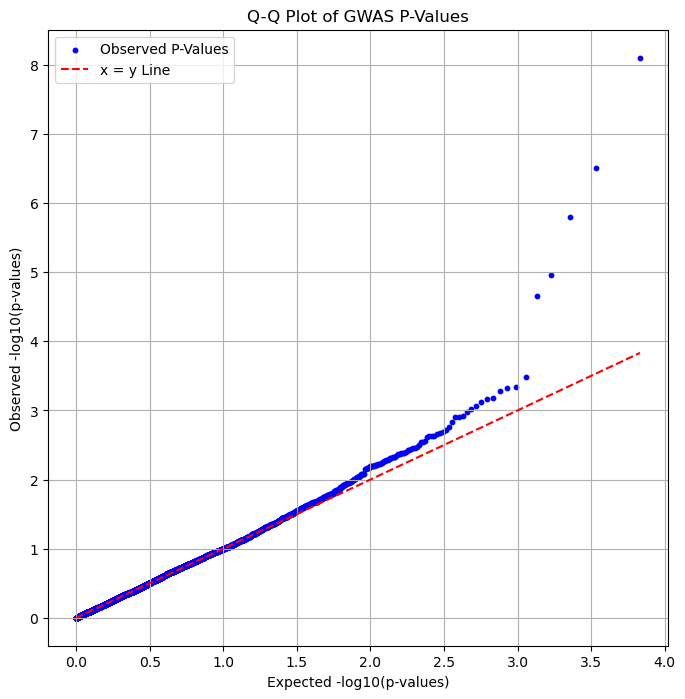

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the observed p-values
observed_pvalues = results_df['PValue']

# Generate expected p-values
n = len(observed_pvalues)
expected_pvalues = np.arange(1, n + 1) / (n + 1)

# Sort and calculate -log10 for both observed and expected p-values
observed_pvalues_sorted = np.sort(observed_pvalues)
expected_pvalues_sorted = -np.log10(expected_pvalues)
observed_minus_log10 = -np.log10(observed_pvalues_sorted)

# Plot the Q-Q plot
plt.figure(figsize=(8, 8))
plt.scatter(expected_pvalues_sorted, observed_minus_log10, s=10, color='blue', label='Observed P-Values')
plt.plot([0, max(expected_pvalues_sorted)], [0, max(expected_pvalues_sorted)], color='red', linestyle='--', label='x = y Line')

# Add labels and title
plt.xlabel('Expected -log10(p-values)')
plt.ylabel('Observed -log10(p-values)')
plt.title('Q-Q Plot of GWAS P-Values')
plt.legend()
plt.grid()
plt.show()


_Figure 14: Q-Q Plot of GWAS p-values_

The density plot in Figure 15 complements these findings by showing a relatively uniform distribution of p-values, which is consistent with the null hypothesis for most variants. The slight clustering of p-values near zero corresponds to the significant SNPs identified in the Q-Q plot, confirming their importance. Together, these plots demonstrate that the results are robust.

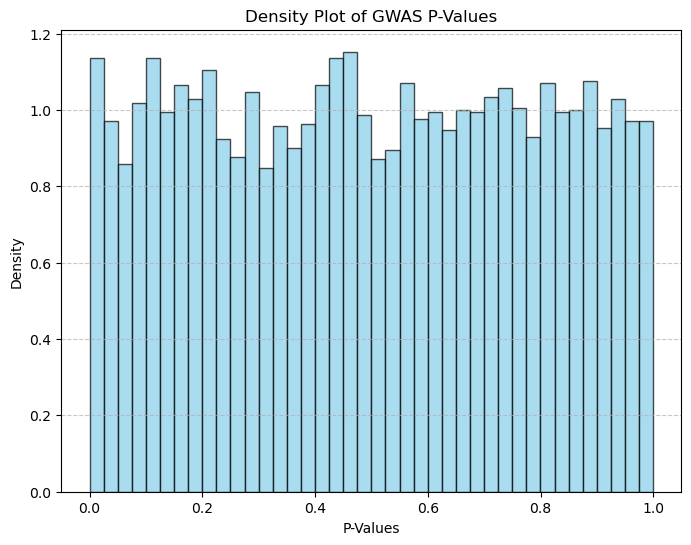

In [60]:
# Create a density plot of the p-values
plt.figure(figsize=(8, 6))
plt.hist(observed_pvalues, bins=40, density=True, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('P-Values')
plt.ylabel('Density')
plt.title('Density Plot of GWAS P-Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


_Figure 15: Density plot of GWAS p-values_

In conclusion, the Q-Q and density plots together validate the GWAS findings. The alignment of most p-values with the null hypothesis confirms the absence of systematic bias, while the deviations identify genuine genetic associations with caffeine consumption. This shows the importance of population structure corrections in producing reliable and biologically meaningful results.

### References 
* (1) National Center for Biotechnology Information (NCBI). (n.d.). dbVar: Database of genomic structural variation. National Library of Medicine. Retrieved December 6, 2024, from https://www.ncbi.nlm.nih.gov/dbvar 
* (2) Open Targets Genetics. (n.d.). CSGALNACT1 (ENSG00000147408). Open Targets Genetics. Retrieved December 6, 2024, from https://genetics.opentargets.org/gene/ENSG00000147408